![alt text](DataKind_orange.png)

### Multiclass Classifier for contract clause types

In [42]:
import os, io
from collections import Counter
from itertools import product
import re, string
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import accuracy_score, classification_report, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from textblob import TextBlob

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('notebook', rc={'figure.figsize': (10, 6)}, font_scale=1.5)

In [43]:
# spacy is used for Part of Speech tagging and Named Entity Recognition
# spacy is a non-standard python library which can be installed using 'pip install spacy' from the command line
# language models can be downloaded by running 'python -m spacy download <language>' from the command line
import spacy
supported_languages = ['en','fr','es']
language_dict = {'en':'english','fr':'french','es':'spanish'}
nlp_langs = {}
for language in supported_languages:
    nlp_langs[language]  = spacy.load(language)

In [44]:
# Downloaded xls file annotations from resourcecontracts and openlandcontracts
resource_folder = 'contract_data/Contracts_Annotations/resource_contracts/'
land_folder = 'contract_data/Contracts_Annotations/openland_contracts/'
# Most recently downloaded metadata from resourcecontracts.org/contracts
rc_metadata = 'contract_data/resource_contract_2017-08-16.csv' 
# Most recently downloaded metadata from openlandcontracts.org/contracts
ol_metadata = 'contract_data/openland_contract_2017-08-16.csv'
# CSV with any incorrect labels to fix
label_fixes = 'contract_data/label_fixes/label_fixes.csv'

metadata_files = [rc_metadata,ol_metadata]
folders = [resource_folder,land_folder]

In [45]:
labels = ['stabilization','royalties'] # list in priority order in case of duplicates
n_folds = 10

In [46]:
annotations = pd.DataFrame()
for folder in folders:
    xls_files = [f for f in os.listdir(folder) if f.lower().endswith('.xls')]
    for xls in xls_files:
        temp = pd.read_excel(folder + xls)
        if len(temp) > 0:
            temp['OCID'] = xls[:-4]
            temp['Source'] = folder.split('/')[-2]
            annotations = annotations.append(temp)
print "Number of annotations: " + str(len(annotations))

Number of annotations: 20609


In [47]:
# drop blank and integer annotations and annotations less than 4 words
annotations.dropna(subset=['Annotation Text'],inplace=True)
annotations = annotations[annotations['Annotation Text'].apply(lambda x: type(x)!=int)].copy()
annotations = annotations[annotations['Annotation Text'].apply(lambda x: len(x.split()) > 3)].copy()
print len(annotations)
# If duplicate text appears within the same contract, drop it
annotations.drop_duplicates(['Annotation Text','OCID','Category'],inplace=True)
print len(annotations)

17885
13795


In [48]:
labels = [label.lower() for label in labels]
annotations['label'] = [x.lower() if x.lower() in labels else 'other' for x in annotations['Category']]

In [49]:
# Given some duplicate text with different Category labels, keep the labels that are in our target label list when dropping
sort_num = range(len(labels) + 1)
sort_key = dict(zip(labels,sort_num))
sort_key['other'] = sort_num[-1]
annotations['sort_key'] = [sort_key[x] for x in annotations['label']]
annotations.sort_values(by='sort_key',inplace=True,ascending=True)
annotations.drop_duplicates(['Annotation Text','OCID'],keep='first',inplace=True)
print len(annotations)

13710


In [50]:
label_fixes = pd.read_csv(label_fixes)
print len(label_fixes)
annotations = annotations.merge(label_fixes[['OCID','Category','Corrected']],how='left',on=['OCID','Category'])
annotations['Corrected'].fillna('',inplace=True)

14


In [51]:
def update_annotations(row):
    if row['Corrected'] == '':
        return row['label']
    else:
        return row['Corrected']
annotations['label'] = annotations.apply(update_annotations,axis=1)

In [52]:
# Join metadata from contracts repository
metadata = pd.DataFrame()
for filename in metadata_files:
    temp = pd.read_csv(filename)
    metadata = metadata.append(temp)
    
annotations = annotations.merge(metadata[['OCID','Language','Country Name','Resource','Contract Type','Document Type']],how='left',on='OCID')

In [53]:
y = list(annotations['label'])
yunique = list(np.unique(y))
for item in yunique:
    print str("{0:.2f}%".format(100*y.count(item) / float(len(y)))) + " " + item

95.74% other
2.47% royalties
1.79% stabilization


In [54]:
annotations.head(2)

,Category,Topic,Annotation Text,PDF Page Number,Article Reference,OCID,Source,label,sort_key,Corrected,Language,Country Name,Resource,Contract Type,Document Type
0,Stabilization,Legal Rules,The government intends to present to the Natio...,4,Preamble,ocds-591adf-1834156729,resource_contracts,stabilization,0,,en,Iraq,Hydrocarbons,Production or Profit Sharing Agreement,Contract
1,Stabilization,Legal Rules,Le gouvernement s'engage aussi à garantir à SG...,17,Art. 11.1,ocds-591adf-9069819553,resource_contracts,stabilization,0,,fr,Senegal,Gold;Silver,Concession Agreement,Contract


In [55]:
def punctuation_remove(text):
    """
    Mutates and returns text where all punctuation besides underscores,
    are replaced
    """
    punctuation_re = r'[^\w\s_]'
    new_text = nltk.regexp.re.sub(punctuation_re, ' ', text)
    return new_text

def replace_numbers(text):
    ''' 
    Removes all characters but periods, commas and alpha-numeric and 
    returns all numeric values replace with the word numeric_value
    '''
#     allowed = {",", "."," ","%"}.union(string.ascii_letters).union([str(num) for num in range(0,10)])
#     filtered = ''.join([character for character in text if character in allowed])
    wordlist = text.split()
    for i in range(len(wordlist)):
        if '$' in wordlist[i]:
            try:
                int(wordlist[i].split('$')[-1].replace(',','').replace('.','').replace('-','').replace(')','').replace('(','').replace('\'','').replace(';','').replace(':',''))
                wordlist[i] = ' '.join(wordlist[i].split('$')[:-1]) + ' dollarvalue'
            except:
                pass
        elif u'\xb0' in wordlist[i]:
            wordlist[i] == 'degreevalue'
        elif '%' in wordlist[i]:
            try: 
                int(wordlist[i].replace(',','').replace('.','').replace('-','').replace('/','').replace('%','').replace(')','').replace('(','').replace('\'','').replace(';','').replace(':',''))
                wordlist[i] = 'percentvalue'
            except:
                pass
        else:
            try: 
                int(wordlist[i].replace(',','').replace('.','').replace('-','').replace('/','').replace(')','').replace('(','').replace('\'','').replace(';','').replace(':',''))
                wordlist[i] = 'numericvalue'
            except:
                pass
    return ' '.join(wordlist)

def perform_lowercase(text):
    """
    Mutates and returns text where all characters are lowercased
    """
    try:
        new_text = text.lower()
    except:
        new_text = str(text).lower()
    return new_text

def underscore_remove(text):
    '''
    replaces multiple underscores with text fillintheblank
    and single underscore with space
    '''
    double_underscore_re = r'(__[a-zA-Z0-9_]*(__)?)'
    text = nltk.regexp.re.sub(double_underscore_re,'fillintheblank',text)
    return text.replace('_',' ')

def doublespace_remove(text):
    return re.sub(' +',' ',text)

def textblobsent(text):
    '''
    returns the TextBlob polarity and subjectivity
    '''
    text = text.encode('ascii','replace')
    sent = TextBlob(text).sentiment
    return pd.Series([sent.polarity,sent.subjectivity])

def get_avg_wordlength(document):
    wordlengths = [len(word) for word in document.split()]
    if len(wordlengths) == 0:
        return 0
    else:
        return np.mean(wordlengths)

def get_multilingual_pos(text,language):
    if language in nlp_langs.keys():
        try:
            tokens = nlp_langs[language](text)
            tags = [token.pos_ for token in tokens]
            counts = Counter(tags).items()
            countdict = {}
            for key, value in counts:
                countdict[key] = value
            return countdict
        except:
            return {'pos_error':1}
    else:
        return {'unsupported_language':1}

def get_multilingual_entities(row):
    
    text = row['CleanText']
    language = row['Language']
    if language in nlp_langs.keys():
        try:
            doc = nlp_langs[language](text)
            labels = [ent.label_ for ent in doc.ents]
            texts = [ent.text for ent in doc.ents]
            starts = [ent.start_char for ent in doc.ents]
            ends = [ent.end_char for ent in doc.ents]
            textlens = [len(word) for word in texts]
            labellens = [len(label) for label in labels]
            diffs = [textlens[i] - labellens[i] for i in range(len(textlens))]
            diffsum = [sum(diffs[0:i]) for i in range(len(diffs))]

            for i in range(len(labels)):
                text = text[0:starts[i] - diffsum[i]] + 'entity' + labels[i] + text[ends[i] - diffsum[i]:]
            return text
        except:
            return text
    else:
        return text
    
def remove_stopwords(row):
    '''
    Multilingual stopwords removal
    '''
    try:
        language = language_dict[row['Language']]
        text = ' '.join([word for word in row['CleanText'].split(' ') if word not in stopwords.words(language)])
        return text
    except:
        return row['CleanText']
    
def stem_words(row):
    ''' 
    Multilingual word stemmer
    '''
    language = language_dict[row['Language']]
    try:
        stemmer = SnowballStemmer(language)
        text = ' '.join([stemmer.stem(word) for word in row['CleanText_NoStop'].split(' ')])
        return text
    except:
        return row['CleanText_NoStop']
    
def clean_metadata(text):
    if type(text) in [float,int]:
        return text
    elif type(text) == str:
        return text.lower().split(';')[0]
    else:
        text = text.encode('ascii','replace')
        return text.lower().split(';')[0]

In [56]:
def clean_text(df):
    df['Annotation Text'].fillna('',inplace=True)
    df['CleanText'] = df['Annotation Text']
    df['CleanText'] = df.apply(get_multilingual_entities,axis=1)
    func_list = [perform_lowercase,replace_numbers,punctuation_remove,underscore_remove, doublespace_remove]
    for func in func_list:
        df['CleanText'] = df['CleanText'].apply(func)

    return df

def featurize(df):
    
    df['AvgWordLength'] = df['CleanText'].apply(get_avg_wordlength)
    
    df['CleanText_NoStop'] = df.apply(remove_stopwords,axis=1)
    df['CleanText_NoStop_Stemmed'] = df.apply(stem_words,axis=1)
    
    postagcounts = []
    entitycounts = []
    for index, row in df.iterrows():
        postagcounts.append(get_multilingual_pos(row['Annotation Text'],row['Language']))    
    postagdf = pd.DataFrame(postagcounts).fillna(0)
    postagdf.index = df.index
    postagdf.columns = ['postag_' + col for col in postagdf.columns]
    
    # create dummy variables for categoricals
    df['Resource'] = df['Resource'].apply(clean_metadata)
    df['Contract Type'] = df['Contract Type'].apply(clean_metadata)
    df['Document Type'] = df['Document Type'].apply(lambda x: x.lower().split(';')[0])
    dummy_cols = ['Language','Country Name','Resource','Contract Type','Document Type']
    dummies = pd.get_dummies(df[dummy_cols],prefix = dummy_cols)
    # drop lowest least frequent dummy columns for each
    for dummy_col in dummy_cols:
        cols = [col for col in dummies.columns if col.startswith(dummy_col)]
        dummies.drop([col for col, val in dummies[cols].sum().iteritems() if val == dummies[cols].sum().min()],axis=1,inplace=True)
    df.drop(dummy_cols, axis=1,inplace=True)
        
    textblobsentdf = df['CleanText'].apply(textblobsent)
    textblobsentdf.columns = ['TextblobPolarity','TextblobSubjectivity']
    df = pd.concat([df,textblobsentdf,postagdf,dummies],axis=1)
    
    return df

In [57]:
annotations = clean_text(annotations)
annotations = featurize(annotations)

In [58]:
tfidf_vectorizer = TfidfVectorizer(max_df= .6,
                                 min_df= .002, 
                                 stop_words=None,  
                                 use_idf=True, 
                                 ngram_range=(1,5))
tfidf_matrix = tfidf_vectorizer.fit_transform(annotations['CleanText_NoStop_Stemmed'].values.astype('U'))
terms = tfidf_vectorizer.get_feature_names()
tfidf_matrix = tfidf_matrix.todense()
tfidf = pd.DataFrame(tfidf_matrix)
tfidf.index = annotations.index
tfidf.columns = terms
print tfidf.shape

(13710, 8449)


In [59]:
exclude = ['Source','Category','Topic','Annotation Text','CleanText','CleanText_NoStop','CleanText_NoStop_Stemmed',
           'OCID','PDF Page Number','Article Reference','MD','VBP','VBZ','VBG','VBD','VBN','other',"''",'label','sort_key','Corrected']
features = [str(col) for col in annotations.columns.tolist() if not col in exclude]

In [60]:
X = pd.concat([tfidf,annotations[features]],axis=1)

In [61]:
X.fillna(0,inplace=True)
X = X.rename(columns = {'fit':'fit_feature'})

In [62]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [63]:
# {u'estimator__min_samples_leaf': 50, 
#  u'estimator__class_weight': u'balanced_subsample', 
#  u'estimator__min_samples_split': 10, 
#  u'estimator__max_features': 0.2, 
#  u'estimator__bootstrap': False, 
#  u'estimator__max_depth': None}

In [64]:
# 10 Fold Accuracy: 0.93040965041
# 10 Fold Recall: 0.88634834166
# model = OneVsRestClassifier(RandomForestClassifier(
#                                                     n_estimators=500,
#                                                     max_features=.2, 
#                                                     min_samples_leaf=50,
#                                                     class_weight='balanced_subsample',
#                                                     min_samples_split=2,
#                                                     bootstrap=True,
#                                                     max_depth=None, 
#                                                     n_jobs=-1))

In [65]:
10 Fold Accuracy: 0.932522903108
10 Fold Recall: 0.911480170017
model = OneVsRestClassifier(RandomForestClassifier(
                                                    n_estimators=500,
                                                    max_features=.2, 
                                                    min_samples_leaf=50,
                                                    class_weight='balanced_subsample',
                                                    min_samples_split=10,
                                                    bootstrap=False,
                                                    max_depth=None, 
                                                    n_jobs=-1))

In [66]:
scoring = {'acc': 'accuracy',
           'rec_macro': 'recall_macro'}
scores = cross_validate(model, X, y, scoring=scoring,
                         cv=n_folds, return_train_score=True)

In [67]:
print str(n_folds) + " Fold Accuracy: " + str(np.mean(scores['test_acc']))
print str(n_folds) + " Fold Recall: " + str(np.mean(scores['test_rec_macro']))

10 Fold Accuracy: 0.932522903108
10 Fold Recall: 0.911480170017


In [68]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
# print str(n_folds) + ' Fold CV Accuracy Score: ' + str(np.mean(cross_val_score(model, X, y, cv=n_folds)))
# model.fit(X_train, y_train)
# test_pred = model.predict(X_test)
# print "Test Set Classification Report \n" + classification_report(y_test, test_pred, target_names=yunique)
# print "Test Set Accuracy: " + str(accuracy_score(y_test, test_pred))

In [69]:
model.fit(X,y)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=False, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features=0.2,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=50,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
          n_jobs=1)

In [70]:
y_pred = cross_val_predict(model,X,y,cv=n_folds)
cnf_matrix = confusion_matrix(y, y_pred)
np.set_printoptions(precision=2)

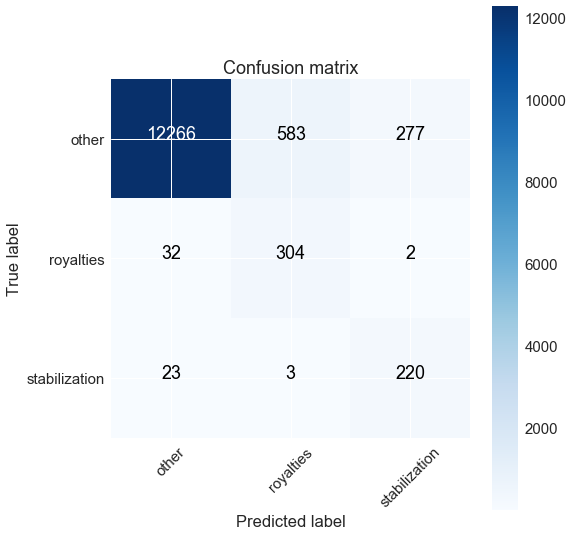

In [71]:
# Plot confusion matrix
sns.set_context(rc={"figure.figsize": (8, 8)})       
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=model.classes_,
                          title='Confusion matrix');

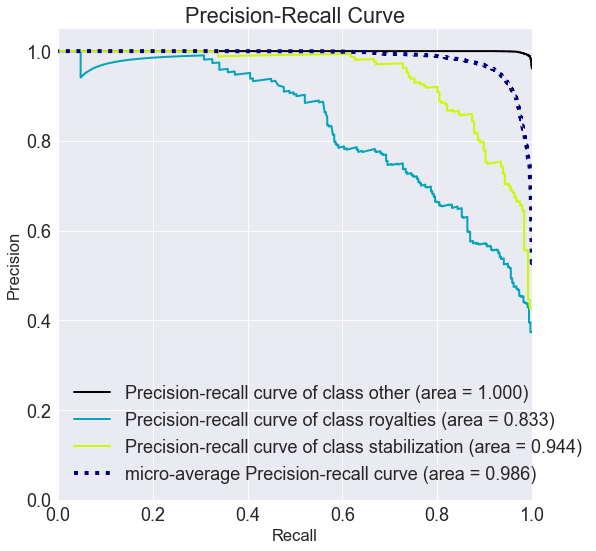

In [72]:
import scikitplot as skplt
probas = model.predict_proba(X)
skplt.metrics.plot_precision_recall_curve(y, probas)
plt.tight_layout()
plt.show()

In [73]:
def get_feature_importances(clf,X):
    '''
    returns feature importances
    '''
    classes = clf.classes_
    feat_importance = {}
    for i in range(len(classes)):
        importances = clf.estimators_[i].feature_importances_
        indices = np.argsort(importances)[::-1]
        feat_importance[classes[i]] = pd.DataFrame(X.columns, importances)    
        feat_importance[classes[i]].reset_index(inplace=True)
        feat_importance[classes[i]].columns = ['Importance','Feature']
        feat_importance[classes[i]].sort_values(by='Importance', axis=0, ascending=True, inplace=True)
        feat_importance[classes[i]].set_index('Feature',inplace=True)
    return feat_importance

Top 20 Features for royalties


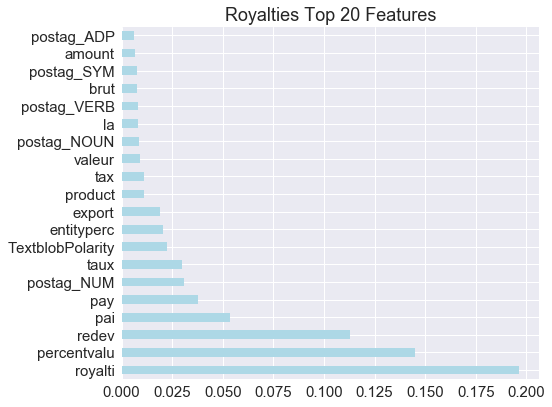

Top 20 Features for stabilization


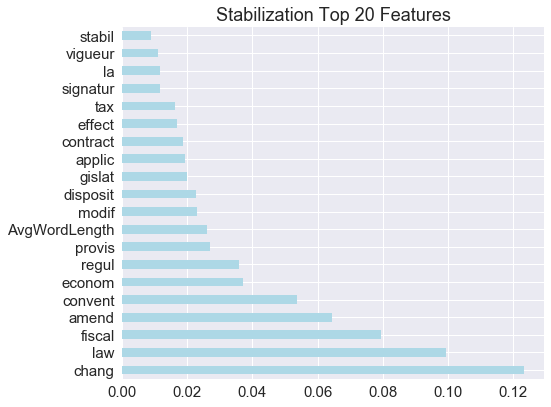

In [74]:
n = 20
sns.set_context(rc={"figure.figsize": (8, 6)})       
importances = {}
importances = get_feature_importances(model,X)
for i in model.classes_[1:]:
    print 'Top ' + str(n) + ' Features for ' + i
    importances[i].index.name=None 
    importances[i].sort_values(by='Importance',ascending=False).head(n).plot(kind='barh',title=i.title() + ' Top ' + str(n) + ' Features',legend=False, color='lightblue')
    plt.tight_layout()
    plt.show()

In [75]:
annotations['Actual'] = y
annotations['Predicted'] = y_pred
annotations['TextLength'] = annotations['CleanText'].str.len()

In [77]:
missed = len(annotations[annotations['Predicted'] != annotations['Actual']])
hit = len(annotations) - missed
print 'Hit: ' + str(hit)
print 'Missed: ' + str(missed)
print 'Accuracy: ' + str(round(hit / float(len(annotations)),3))

Hit: 12790
Missed: 920
Accuracy: 0.933


In [78]:
false_positives = annotations[(annotations['Predicted'] != annotations['Actual']) 
                              & (annotations['Predicted'] != 'other')]
false_negatives = annotations[(annotations['Predicted'] != annotations['Actual']) 
                              & (annotations['Predicted'] == 'other')]
true_positives = annotations[(annotations['Predicted'] == annotations['Actual']) 
                              & (annotations['Predicted'] != 'other')]
print 'False Positives: ' + str(len(false_positives))
print 'False Negatives: ' + str(len(false_negatives))

False Positives: 865
False Negatives: 55


In [83]:
false_positives[false_positives['Language_en'] == 1][['OCID','Category','Predicted','CleanText','TextLength']].to_csv('results_classification/False_Positives_20171117.csv')

In [84]:
false_negatives[['OCID','Category','Predicted','CleanText','TextLength']].to_csv('results_classification/False_Negatives_20171117.csv')